In [12]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí AR modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19*

Uvažujme datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Datová sada obsahující kumulativní denní počty osob s prokázaným onemocněním COVID-19 dle hlášení krajských hygienických stanic včetně laboratoří, denní počty vyléčených po onemocnění COVID‑19 dle hlášení krajských hygienických stanic, denní počty úmrtí v souvislosti s onemocněním COVID‑19 dle hlášení krajských hygienických stanic a hospitalizačních úmrtí, a denní počty provedených testů na onemocnění COVID-19 dle hlášení laboratoří. S ohledem na fakt, že vykazování vyléčených osob a úmrtí má určité zpoždění oproti reálnému stavu z důvodu validace a uzavírání případů krajských hygienických stanic, se mohou denní záznamy zpětně měnit právě z důvodu průběžného doplňování.```

Jelikož poskytovatel nedává schema CSV k první verzi automaticky, budeme si muset data sami prozkoumat :)



In [74]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.head()

,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu,kumulovany_pocet_provedenych_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
datum,,,,,,,,,,
2020-01-27,0,0,0,20,0,0,0,0,20,0
2020-01-28,0,0,0,28,0,0,0,0,8,0
2020-01-29,0,0,0,33,0,0,0,0,5,0
2020-01-30,0,0,0,34,0,0,0,0,1,0
2020-01-31,0,0,0,37,0,0,0,0,3,0


Zaměříme se na přírůstkový počet provedených antigenních testů v několika posledních týdnech. Mají data nějaké význačné vlastnosti?

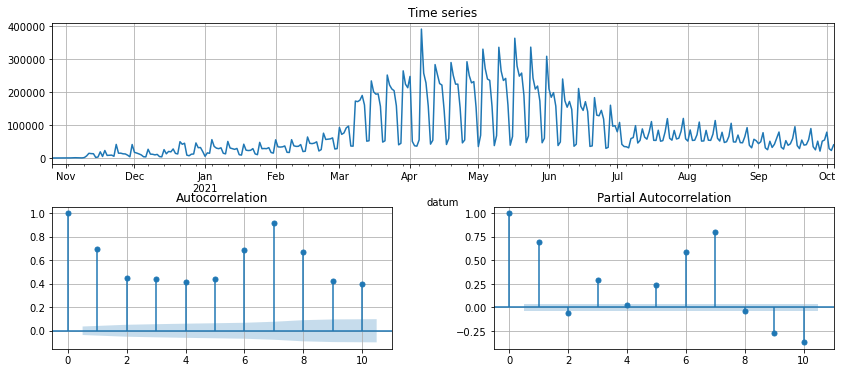

In [14]:
df = data['prirustkovy_pocet_provedenych_ag_testu'].last('50W')
df = df.asfreq('D')

tsplot(df, lags=10)

Jelikož jsme se zatím neseznámili s problematikou sezónnosti, budeme pracovat na týdenních součtech. To může být dokonce vhodné, neboť tím dostáváme poměrně rozumná data, která nevyžadují komplexní model a současně dokážou schovat různé anomálie. Podobně může být praktické pracovat na průměrech apod.

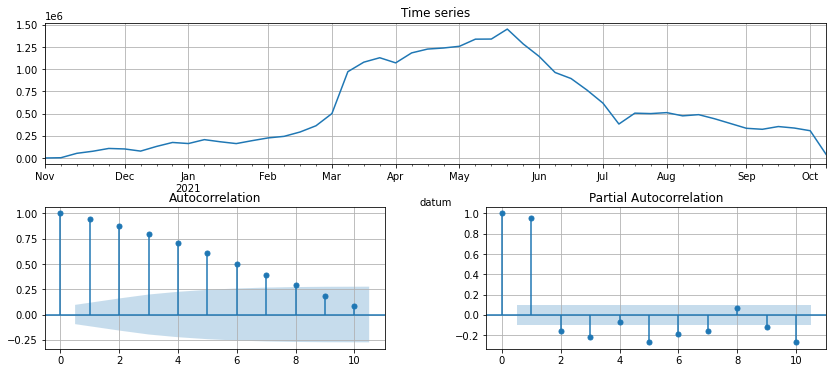

In [15]:
df_analysis = df.resample('W').sum()
tsplot(df_analysis, lags=10)

Zkusme nyní nějak uhodnout, jaký ARMA model by mohl být vhodný. K tomu nám může posloužit funkce `arma_order_select_ic()`, podobná funkci `ar_select_order()` z minulého cvičení:

In [17]:
arma_order_select_ic(df_analysis, ic='aic', trend='c')

/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:726: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:410: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:496: RuntimeWarning: invalid value encountered in double_scalars
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.


{'aic':              0            1            2
 0  1445.759917  1397.055490  1357.465671
 1  1311.069043  1307.490474  1303.891352
 2  1304.012267  1301.300473  1301.913833
 3  1304.195256  1303.511291  1305.460290
 4  1305.974471  1305.492230          NaN,
 'aic_min_order': (2, 1)}

Zkusme nafitovat model. Ačkoliv chceme ARMA, použijeme ARIMA, protože s ním budeme v budoucnosti hojně pracovat:

In [77]:
model = ARIMA(df_analysis, order=(3,0,1), trend='n')
res = model.fit()
print(res.summary())

                                         SARIMAX Results                                          
Dep. Variable:     prirustkovy_pocet_provedenych_ag_testu   No. Observations:                   50
Model:                                     ARIMA(3, 0, 1)   Log Likelihood                -646.058
Date:                                    Tue, 05 Oct 2021   AIC                           1302.115
Time:                                            17:00:15   BIC                           1311.675
Sample:                                        11-01-2020   HQIC                          1305.756
                                             - 10-10-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6078      0.260      2.334      0

## Diagnostika - kritéria a obrázky

Minule jsme se seznámili s informačními kritérii AIC a BIC. Zajímat by nás dále mohly různé metriky, jako střední kvadratická chyba predikce ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) a střední absolutní chyba predikce ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)). Označíme-li $y_t$ skutečnou pozorovanou hodnotu veličiny v čase $t$ na horizontu $T$, $\hat{y}_t$ její modelem predikovanou hodnotu a reziduum $\tilde\varepsilon_t = \hat{y}_t - y_t$, potom

$$
\operatorname{MSE} = \frac{1}{T} \sum_{t=1}^t \tilde\varepsilon_t^2, \qquad \operatorname{MAE} = \frac{1}{T} \sum_{t=1}^T |\tilde\varepsilon_t|.
$$

Ve `statsmodels` na to máme vlastnosti `mae` a `mse`. Pro úplnost doplňme, že rezidua jsou ve vlastnosti `resid` a že `sse` obsahuje "sum of squared errors", tedy sumu kvadrátů reziduí:

In [81]:
print(f'MAE = {res.mae:.4f}')
print(f'MSE = {res.mse:.4f}')

MAE = 58693.9828
MSE = 8936232636.1895


Diagnostické obrázky známe z minule, ale popišme si je tentokrát podrobněji:

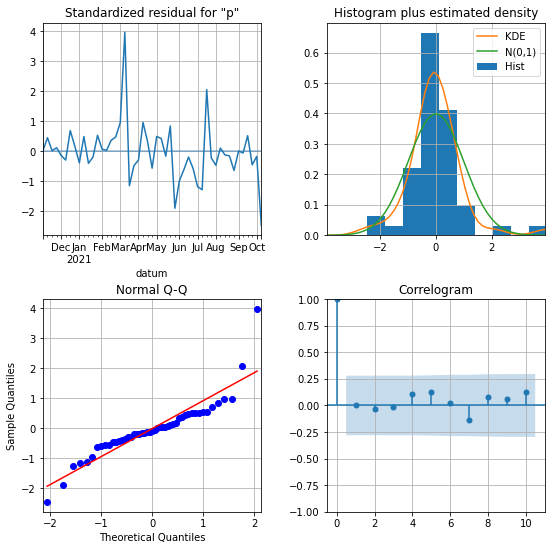

In [69]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Metoda `plot_diagnostics()` vykreslí:
- vývoj standardizovaných rezidui, tj. chyb predikce po odečtení průměru a vydělení směrodatnou odchylkou. Neradi bychom viděli trend nebo nějaké "vzory";
- histogram standardizovaných reziduí spolu s jádrovým (KDE) odhadem a hustotou $\mathcal{N}(0,1)$, které bychom se rádi co nejvíce přiblížili;
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) zobrazující podobu kvantilů rozdělení $\mathcal{N}(0,1)$ a našich reziduí. Ideálem je, aby body ležely na úhlopříčce;
- Korelogram - už známou ACF reziduí.

## Diagnostika - testy

**Nejprve o testech obecně, potom si aplikujte novou znalost na výsledek z modelování časové řady výše.**

Připomeňme si letem světem základní princip testování hypotéz. Zavádíme:
- **nulovou hypotézu** $H_0$ - základní hypotéza, její platnost chceme v ideálním případě zamítnout (*reject*).
- **alternativní hypotézu** $H_1$ či $H_A$ - zamítáme-li $H_0$, pak ve prospěch této hypotézy.

V případě analýzy časových řad jsou testy zpravidla **oboustranné**, kde $H_0$ říká, že hodnota testovaného parametru je rovna nějakému číslu, proti $H_1$ která předpokládá nerovnost. Připomeňme, že jednostranné testy by tvrdily, že hodnota parametru je buď větší (pravostranný test), nebo menší (test levostranný).

Jsou dva možné výsledky statistického testu:
- **zamítáme $H_0$** (ve prospěch hyp. alternativní) - tj. máme dostatek statistických důkazů (evidence) v její neprospěch. Anglicky: *reject H_0*.
- **nezamítáme $H_0$** - nemáme dostatek statistických důkazů proti její platnosti. Tím ale $H_0$ nepotvrzujeme!!! Anglicky: *fail to reject $H_0$*.

Testování provádíme na hladině testu (též významnosti) $\alpha\in[0,1]$, zpravidla 0.05 či nižší. Tato hladina nám říká, jaká je pravděpodobnost, že $H_0$ bude neoprávněně zamítnuta.

Testování je založeno na testové statistice s obvykle nějakým známým vhodným rozdělením (typicky Studentovým $t$ apod.). Za platnosti $H_0$ nabývá tato veličina hodnost z nějakého oboru (vzpomeňte intervaly spolehlivosti) s pravděpodobností $1-\alpha$ a s pravděpodobností $\alpha$ potom z oboru kritického. Pokud hodnota statistiky leží v kritickém oboru, $H_0$ zamítáme.

Software zpravidla počítá **p-hodnotu**, tj. pravděpodobnost, že by testovací statistika dosáhla své hodnoty či hodnot ještě více svědčících proti $H_0$ při platnosti $H_0$. Z wikipedie:

> p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.

#### Z-test koeficientů

Test ověřuje nenulovost jednotlivých koeficientů modelu, např. pro ARMA(1,0) máme hypotézu o AR koeficientu $\phi_1$ v 1. zpoždění v podobě
$$
\begin{aligned}
H_0&: \phi_1 \equiv \text{AR.L1} = 0, \\
H_1&: \phi_1 \equiv \text{AR.L1} \ne 0.
\end{aligned}
$$

Test počítá $Z$ statistiku, $p$-hodnotu a $(1-\alpha)\%$ interval spolehlivosti pro příslušné koeficienty. Zajímají nás především nejvyšší koeficienty modelu, např. pro ARMA(2, 3) by to byly $\phi_2$ a $\theta_3$.

#### Ljungův-Boxův Q test
Test ověřuje nekorelovanost časové řady, v případě výsledku fitování jde o nekorelovanost standardizovaných reziduí (chyb predikce):

$$
\begin{aligned}
H_0&: \text{data jsou nekorelovaná}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika pro $n$ dat, zpoždění $k$ a výběrový autokorelační koeficient $r_k$ má na horizontu testování $h$ podobu

$$
Q = n(n+2) \sum_{k=1}^h \frac{r_k^2}{n-k} \sim \chi_{h}^2.
$$

Při testování nekorelovanosti reziduí z modelu ARIMA(p, 0, q) je počet stupňů volnosti $h-p-q$. Jednodušší variantou je Boxův-Pierceův test, který `statsmodels` rovněž umí.

#### Test heteroskedasticity

Test ověřuje, zda jsou standardizovaná rezidua (chyby regrese) heteroskedastická, tj. mají proměnnou varianci:

$$
\begin{aligned}
H_0&: \text{rezidua nejsou heteroskedastická}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

V implementaci se rozdělí data na tři třetiny a testuje se, zda je součet kvadrátů reziduí v dřívější třetině větší než součet kvadrátů reziduí v pozdější třetině. Označme $h=\lfloor n/3 \rfloor$ kde $n$ je počet dat, $d$ počet zahozených počátečních (burn-in) reziduí a rezidua $\tilde\varepsilon_t$;   testovací statistika má podobu

$$
H(h) = \frac{\sum_{t=n-h+1}^n \tilde\varepsilon_t^2}{\sum_{t=d+1}^{d+1+h} \tilde\varepsilon_t^2} \sim F_{h,h}.
$$

Jde tedy o [Fisherův $F$-test](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances).

#### Jarque-Bera test

Test ověřuje složenou hypotézu, že data mají výběrovou [šikmost](https://en.wikipedia.org/wiki/Skewness) $g_1=0$ a výběrovou [špičatost](https://en.wikipedia.org/wiki/Kurtosis) $g_2=3$, stejně jako normální rozdělení:

$$
\begin{aligned}
H_0&: \text{rezidua mají $g_1=0, g_2=3$}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika je asymptoticky $\chi^2$ rozdělená, pro $n$ dat má podobu

$$
JB = \frac{n}{6}\left(g_1^2 + \frac{(g_2 - 3)^2}{4}\right) \sim \chi_2^2.
$$

Pro malé rozsahy výběru se nutné využívat lepší aproximace, neboť $\chi^2$ aproximace není dostatečná. V implementaci se podobně jako u předešlého testu vynechává určitý počet počátečních dat (reziduí).

## Predikce

Kreslení predikcí bohužel není tak jednoduché, jako s `AutoReg`. Nejprve si musíme predikce napočítat:

In [78]:
preds = res.get_prediction(end='2021-11-01')
preds.summary_frame().head()

prirustkovy_pocet_provedenych_ag_testu,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-11-01,0.000000,632688.168797,-1.240046e+06,1.240046e+06
2020-11-08,0.000000,116272.321046,-2.278896e+05,2.278896e+05
2020-11-15,4309.722619,105405.500569,-2.022813e+05,2.109007e+05
2020-11-22,69034.502276,103507.103109,-1.338357e+05,2.719047e+05
2020-11-29,93968.692059,102499.632559,-1.069269e+05,2.948643e+05


...a až následně můžeme kreslit:

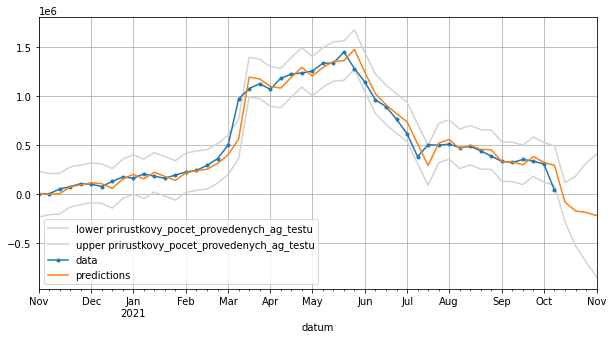

In [71]:
ci = preds.conf_int()

fig = ci.plot(color='lightgrey', figsize=(10, 5))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
plt.legend()
plt.show()

Ryze pro zajímavost: viděli jsme výše, že PACF v prvním lagu má hodnotu velmi blízkou 1. To by mohlo naznačovat, že v datech je "schována" náhodná procházka. Co kdybychom zkusili diferencování? ;-)